In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import plot_model

2024-05-28 12:21:06.223011: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 12:21:06.223107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 12:21:06.355797: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Reading Data**

In [3]:
train_path = "/kaggle/input/nasa-turbofan/train_FD001.csv"
test_path = "/kaggle/input/nasa-turbofan/test_FD001.csv"
RUL_path = "/kaggle/input/nasa-turbofan/RUL_FD001.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
RUL_data = pd.read_csv(RUL_path)

In [4]:
train_data.head()

,Unnamed: 0,unit number,time in cycles,operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
test_data.head()

,Unnamed: 0,unit number,time in cycles,operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [6]:
RUL_data.head()

,Unnamed: 0,RUL,unit number
0,0,112,1
1,1,98,2
2,2,69,3
3,3,82,4
4,4,91,5


# **Preprocess Data**

**1- Remove some columns:**

In [7]:
train_data.drop(['Unnamed: 0','operational setting 3', 'sensor measurement 1', 'sensor measurement 5',
                 'sensor measurement 10', 'sensor measurement 16','sensor measurement 19', 'sensor measurement 19'], axis=1, inplace=True)

test_data.drop(['Unnamed: 0','operational setting 3', 'sensor measurement 1', 'sensor measurement 5',
                 'sensor measurement 10', 'sensor measurement 16','sensor measurement 19', 'sensor measurement 19'], axis=1, inplace=True)

RUL_data.drop(['Unnamed: 0'], axis=1, inplace=True)

train_data.head()

,unit number,time in cycles,operational setting 1,operational setting 2,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 6,sensor measurement 7,sensor measurement 8,sensor measurement 9,sensor measurement 11,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 17,sensor measurement 18,sensor measurement 20,sensor measurement 21
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,2388,39.06,23.4190
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,2388,39.00,23.4236
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,2388,38.95,23.3442
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,2388,38.88,23.3739
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,2388,38.90,23.4044


**2- Labeling:**

**Train_data Labeling**

In [8]:
train_data['RUI'] = 0
for i in range(1, 101):
    cycles = train_data[train_data['unit number']==i]['time in cycles']
    last_cycle = cycles.iloc[-1]
    RUI = last_cycle - cycles
    train_data.loc[train_data['unit number'] == i, 'RUI'] = RUI
    
train_data['RUI'] = np.where(train_data['RUI'].values>130, 130, train_data['RUI'])
cls_labels = np.where(train_data['RUI'].values>50, 0, 1)
train_data['Cls_labels'] = cls_labels
train_data.head()

,unit number,time in cycles,operational setting 1,operational setting 2,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 6,sensor measurement 7,sensor measurement 8,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 17,sensor measurement 18,sensor measurement 20,sensor measurement 21,RUI,Cls_labels
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,...,521.66,2388.02,8138.62,8.4195,392,2388,39.06,23.4190,130,0
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,...,522.28,2388.07,8131.49,8.4318,392,2388,39.00,23.4236,130,0
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,...,522.42,2388.03,8133.23,8.4178,390,2388,38.95,23.3442,130,0
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,...,522.86,2388.08,8133.83,8.3682,392,2388,38.88,23.3739,130,0
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,...,522.19,2388.04,8133.80,8.4294,393,2388,38.90,23.4044,130,0


In [9]:
train_data['Cls_labels'].value_counts()

Cls_labels
0    15531
1     5100
Name: count, dtype: int64

**Test Data Labeling**

In [10]:
test_data['RUI'] = 0
for i in range(1, 101):
    cycles = test_data[test_data['unit number']== i]['time in cycles']
    last_working_cycle = cycles.iloc[-1]
    last_cycle = RUL_data[RUL_data['unit number'] == i]['RUL'].values[0]
    RUI = last_cycle + last_working_cycle - cycles
    test_data.loc[test_data['unit number'] == i, 'RUI'] = RUI
    
test_data['RUI'] = np.where(test_data['RUI'].values>130, 130, test_data['RUI'])    
cls_labels = np.where(test_data['RUI'].values>50, 0, 1)
test_data['Cls_labels'] = cls_labels
test_data.head()

,unit number,time in cycles,operational setting 1,operational setting 2,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 6,sensor measurement 7,sensor measurement 8,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 17,sensor measurement 18,sensor measurement 20,sensor measurement 21,RUI,Cls_labels
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,21.61,553.90,2388.04,...,521.72,2388.03,8125.55,8.4052,392,2388,38.86,23.3735,130,0
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,21.61,554.85,2388.01,...,522.16,2388.06,8139.62,8.3803,393,2388,39.02,23.3916,130,0
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,21.61,554.11,2388.05,...,521.97,2388.03,8130.10,8.4441,393,2388,39.08,23.4166,130,0
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,21.61,554.07,2388.03,...,521.38,2388.05,8132.90,8.3917,391,2388,39.00,23.3737,130,0
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,21.61,554.16,2388.01,...,522.15,2388.03,8129.54,8.4031,390,2388,38.99,23.4130,130,0


In [11]:
test_data['Cls_labels'].value_counts()

Cls_labels
0    12210
1      886
Name: count, dtype: int64

**3 - Split and Normalize**

In [12]:
train_features = train_data.drop(['RUI', 'Cls_labels','unit number', 'time in cycles'], axis=1)
train_target = train_data[['RUI', 'Cls_labels']]

test_features = test_data.drop(['RUI', 'Cls_labels', 'unit number', 'time in cycles'], axis=1)
test_targets = test_data[['RUI', 'Cls_labels']]

In [13]:
scaler = MinMaxScaler()

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

**4- Time windows**

In [15]:
feature_colmns = ['operational setting 1',
       'operational setting 2', 'sensor measurement 2', 'sensor measurement 3',
       'sensor measurement 4', 'sensor measurement 6', 'sensor measurement 7',
       'sensor measurement 8', 'sensor measurement 9', 'sensor measurement 11',
       'sensor measurement 12', 'sensor measurement 13',
       'sensor measurement 14', 'sensor measurement 15',
       'sensor measurement 17', 'sensor measurement 18',
       'sensor measurement 20', 'sensor measurement 21']

train_target.loc[:,'unit number'] = train_data.loc[:,'unit number']
train_features = pd.DataFrame(train_features, columns=feature_colmns)
train_features.loc[:,'unit number'] = train_data.loc[:,'unit number']

In [16]:
window_size = 30
train_vectors = []
target_vectors = []
for i in range(1, 101):
    
    unit_data = train_features[train_features['unit number'] == i].values
    unit_target = train_target[train_target['unit number'] == i].values
    
    for j in range(len(unit_data) - window_size + 1):
        window_vec = unit_data[j:j+window_size, :-1]
        window_tar = unit_target[j:j+window_size, :-1]

        train_vectors.append(window_vec)
        target_vectors.append(window_tar)
    
train_vectors = np.array(train_vectors)
target_vectors = np.array(target_vectors)


train_target_reg = target_vectors[:,:,0]
train_target_cls = target_vectors[:,:,1]

window_train_target_reg = train_target_reg[:,-1]
window_train_target_cls = train_target_cls[:,-1]

print(train_target_reg.shape)
print(train_target_cls.shape)

print(train_vectors.shape)
print(window_train_target_reg.shape)
print(window_train_target_cls.shape)

(17731, 30)
(17731, 30)
(17731, 30, 18)
(17731,)
(17731,)


In [17]:
np.bincount(window_train_target_cls)

array([12631,  5100])

In [19]:
test_targets.loc[:,'unit number'] = test_data.loc[:,'unit number']
test_features = pd.DataFrame(test_features, columns=feature_colmns)
test_features.loc[:,'unit number'] = test_data.loc[:,'unit number']

In [20]:
window_size = 30
test_vectors = []
target_vectors = []
for i in range(1, 101):
    
    unit_data = test_features[test_features['unit number'] == i].values
    unit_target = test_targets[test_targets['unit number'] == i].values
    
    for j in range(len(unit_data) - window_size + 1):
        window_vec = unit_data[j:j+window_size, :-1]
        window_tar = unit_target[j:j+window_size, :-1]

        test_vectors.append(window_vec)
        target_vectors.append(window_tar)
    
test_vectors = np.array(test_vectors)
target_vectors = np.array(target_vectors)


test_target_reg = target_vectors[:,:,0]
test_target_cls = target_vectors[:,:,1]
window_test_target_reg = test_target_reg[:,-1]
window_test_target_cls = test_target_cls[:,-1]

print(test_target_reg.shape)
print(test_target_cls.shape)

print(test_vectors.shape)
print(window_test_target_reg.shape)
print(window_test_target_cls.shape)

(10196, 30)
(10196, 30)
(10196, 30, 18)
(10196,)
(10196,)


In [21]:
np.bincount(window_test_target_cls)

array([9310,  886])

# **Dataset:**

In [22]:
BATCH_SIZE = 200
EPOCHS=100

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_vectors, {'classification_output':window_train_target_cls, 'regression_output':window_train_target_reg}))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_vectors, {'classification_output':window_test_target_cls, 'regression_output':window_test_target_reg}))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [24]:
data, tar = next(iter(train_dataset))
print(data.shape)
print(tar['classification_output'].shape)
print(tar['regression_output'].shape)

(200, 30, 18)
(200,)
(200,)


# **Helper Function**

In [25]:
def plot_classifier(classifier_history, name='CNN-LSTM Classifier'):
    
    plt.figure(figsize=(9,5))
    plt.suptitle(name)

    plt.subplot(1,2,1)
    plt.plot(classifier_history.history['loss'], label='Train loss')
    plt.plot(classifier_history.history['val_loss'], label='Validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss')
    # plt.ylim([0, 4000])
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(classifier_history.history['accuracy'], label='Train ACC')
    plt.plot(classifier_history.history['val_accuracy'], label='Validation ACC')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.title('Accuracy')
    # plt.ylim([0.8,1.001])
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

In [26]:
def report_matrix_ROC(classifier_model, test_dataset, test_target_cls):
    
    predict = classifier_model.predict(test_dataset)
    prediction = np.where(predict>=0.5,1,0)
    report = classification_report(prediction, test_target_cls)
    print(report)
    
    print('\n#################################################################\n')
    
    mat = confusion_matrix(prediction, test_target_cls)
    sns.heatmap(mat, annot=True, fmt='0.2f', cmap='coolwarm')
    plt.show()
    
    print('\n#################################################################\n')

    fpr, tpr, _ = roc_curve(prediction, test_target_cls)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    


In [27]:
def plot_regressor(regressor_history, name='CNN-LSTM Regressor'):
    
    plt.figure(figsize=(10,10))
    plt.suptitle(name)

    plt.subplot(2,2,1)
    plt.plot(regressor_history.history['loss'], label='Train MSE')
    plt.plot(regressor_history.history['val_loss'], label='Validation MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epochs')
    plt.title('MSE')
    # plt.ylim([0, 4000])
    plt.legend()
    plt.grid()

    plt.subplot(2,2,2)
    plt.plot(regressor_history.history['mae'], label='Train MAE')
    plt.plot(regressor_history.history['val_mae'], label='Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epochs')
    plt.title('MAE')
    # plt.ylim([0.8,1.001])
    plt.legend()
    plt.grid()

    plt.subplot(2,2,3)
    plt.plot(regressor_history.history['mape'], label='Train MAPE')
    plt.plot(regressor_history.history['val_mape'], label='Validation MAPE')
    plt.ylabel('MAPE')
    plt.xlabel('Epochs')
    plt.title('MAPE')
    # plt.ylim([0.8,1.001])
    plt.legend()
    plt.grid()

    plt.subplot(2,2,4)
    plt.plot(regressor_history.history['rmse'], label='Train RMSE')
    plt.plot(regressor_history.history['val_rmse'], label='Validation RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('Epochs')
    plt.title('RMSE')
    # plt.ylim([0.8,1.001])
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    


In [28]:
def evaluate_model(regressor_model, test_dataset, test_features, RUL_data, window_size=30):
    
    window_size = 30
    test_vectors_for_test = []
    for i in range(1, 101):

        unit_data_for_test = test_features[test_features['unit number'] == i].values

        for j in range(len(unit_data_for_test) - window_size + 1):
            window_vec_for_test = unit_data_for_test[j:j+window_size, :-1]

        test_vectors_for_test.append(window_vec_for_test)

    test_vectors_for_test = np.array(test_vectors_for_test)
    X = test_vectors_for_test
    y = RUL_data['RUL'].values
    
    
    all_window = regressor_model.evaluate(test_dataset)
    print(f'all_window MSE: {all_window[0]:0.2f}')
    print(f'all_window MAE: {all_window[1]:0.2f}')
    print(f'all_window MAPE: {all_window[2]:0.2f}')
    print(f'all_window RMSE: {all_window[3]:0.2f}')
    
    print('\n####################################################\n')
    
    last_window_per_test_data = regressor_model.evaluate(X,y)
    print(f'last_window_per_test_data MSE: {last_window_per_test_data[0]:0.2f}')
    print(f'last_window_per_test_data MAE: {last_window_per_test_data[1]:0.2f}')
    print(f'last_window_per_test_data MAPE: {last_window_per_test_data[2]:0.2f}')
    print(f'last_window_per_test_data RMSE: {last_window_per_test_data[3]:0.2f}')
    
    print('\n####################################################\n')

    
    last_window = regressor_model.evaluate(np.expand_dims(X[-1], axis=0), np.expand_dims(y[-1], axis=0))
    print(f'last_window MSE: {last_window[0]:0.2f}')
    print(f'last_window MAE: {last_window[1]:0.2f}')
    print(f'last_window MAPE: {last_window[2]:0.2f}')
    print(f'last_window RMSE: {last_window[3]:0.2f}')

    return X, y

In [29]:
def plot_regression_point(regressor_model, X, y, RUL_data, name='RUL: Real vs Pred'):

    y_pred = regressor_model.predict(X)
    y_pred.shape
    RUL_data['Pred'] = y_pred.squeeze()
    soreted_RUL = RUL_data.sort_values(by='RUL')
    RUL_data.drop(['Pred'], axis=1, inplace=True)
    
    engine_numbers = range(len(soreted_RUL['RUL']))
    act_values = soreted_RUL['RUL'].values
    pred_values = soreted_RUL['Pred'].values

    plt.figure(figsize=(15,5))
    plt.scatter(engine_numbers, act_values, s=10, c='red', label="True RUL")
    plt.scatter(engine_numbers, pred_values, s=10, c='g', label="Pred RUL")

    for i in range(len(engine_numbers)):
        plt.plot([engine_numbers[i], engine_numbers[i]], [act_values[i], pred_values[i]], color='black', alpha=0.5)

    plt.title(name)
    plt.legend()
    plt.xlabel('Engine number')
    plt.ylabel('RUL')
    plt.show()

# **CNN-LSTM Classifier Model:**

In [29]:
input_shape = (train_vectors.shape[1], train_vectors.shape[2])
input_layer = Input(shape=input_shape)
x = Conv1D(32, 5, activation='relu')(input_layer)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = LSTM(50, return_sequences=True, dropout=0.2)(x)
x = Dropout(0.2)(x)
x = LSTM(50, dropout=0.2)(x)
x = Dropout(0.2)(x)
# x = Dense(512, activation='relu')(x)
classification_output = Dense(1, activation='sigmoid', name='classification_output')(x)
regression_output = Dense(1, activation='linear', name='regression_output')(x)
classifier_model = Model(inputs=input_layer, outputs=classification_output) #outputs=[classification_output, regression_output])
classifier_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 26, 32)         │         2,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8, 50)          │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_output (Dense)   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,371 (204.57 KB)

 Trainable params: 52,371 (204.57 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
classifier_model.compile(
    optimizer='adam',
    loss= {'classification_output': 'binary_crossentropy'},     #{'classification_output': 'binary_crossentropy', 'regression_output': 'mean_squared_error'},
    metrics={'classification_output': ['accuracy']},            #{'classification_output': ['accuracy'], 'regression_output': ['mse']}
)

classifier_history = classifier_model.fit(train_dataset,
          validation_data=test_dataset,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7416 - loss: 0.5208 - val_accuracy: 0.9324 - val_loss: 0.2032
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8716 - loss: 0.3037 - val_accuracy: 0.9409 - val_loss: 0.1685
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8937 - loss: 0.2703 - val_accuracy: 0.9468 - val_loss: 0.1512
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9103 - loss: 0.2380 - val_accuracy: 0.9569 - val_loss: 0.1325
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9211 - loss: 0.2085 - val_accuracy: 0.9617 - val_loss: 0.1321
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9277 - loss: 0.1882 - val_accuracy: 0.9611 - val_loss: 0.1288
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9269 - loss: 0.1824 - val_accuracy: 0.9608 - val_loss: 0.1256
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9337 - loss: 0.1711 - val_accuracy: 0

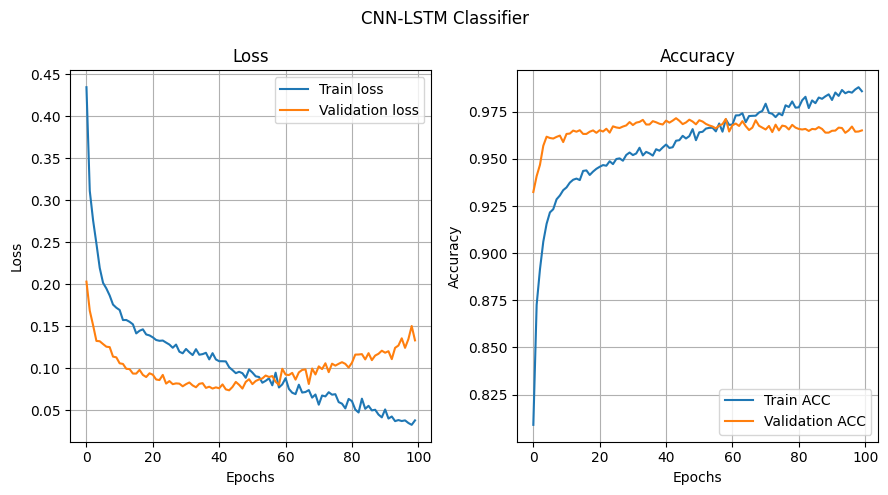

In [31]:
plot_classifier(classifier_history, name='CNN-LSTM Classifier')

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9340
           1       0.78      0.81      0.80       856

    accuracy                           0.97     10196
   macro avg       0.88      0.89      0.89     10196
weighted avg       0.97      0.97      0.97     10196


#################################################################



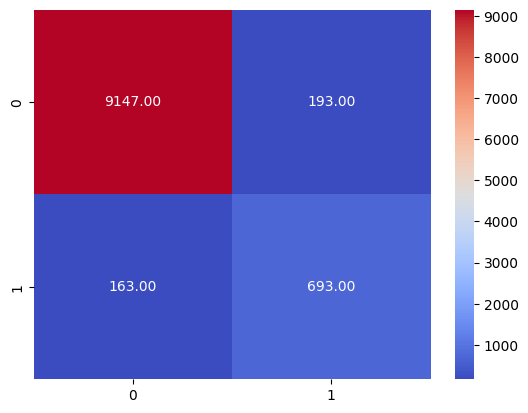


#################################################################



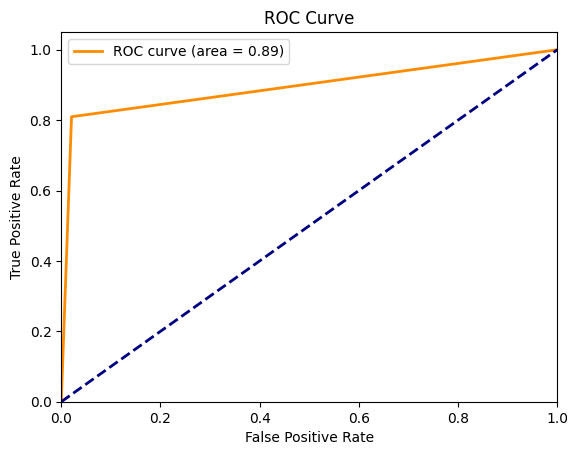

In [32]:
report_matrix_ROC(classifier_model, test_dataset, window_test_target_cls)

# **Classifier with Early Stopping**

In [33]:
input_shape = (train_vectors.shape[1], train_vectors.shape[2])
input_layer = Input(shape=input_shape)
x = Conv1D(32, 5, activation='relu')(input_layer)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = LSTM(50, return_sequences=True, dropout=0.2)(x)
x = Dropout(0.2)(x)
x = LSTM(50, dropout=0.2)(x)
x = Dropout(0.2)(x)
# x = Dense(512, activation='relu')(x)
classification_output = Dense(1, activation='sigmoid', name='classification_output')(x)
# regression_output = Dense(1, activation='linear', name='regression_output')(x)
classifier_model = Model(inputs=input_layer, outputs=classification_output) #outputs=[classification_output, regression_output])
# classifier_model.summary()

In [34]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

classifier_model.compile(
    optimizer='adam',
    loss= {'classification_output': 'binary_crossentropy'},     #{'classification_output': 'binary_crossentropy', 'regression_output': 'mean_squared_error'},
    metrics={'classification_output': ['accuracy']},            #{'classification_output': ['accuracy'], 'regression_output': ['mse']}
)

classifier_history = classifier_model.fit(train_dataset,
          validation_data=test_dataset,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[early_stopping])

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.7391 - loss: 0.5293 - val_accuracy: 0.9254 - val_loss: 0.2023
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8616 - loss: 0.3262 - val_accuracy: 0.9404 - val_loss: 0.1720
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8876 - loss: 0.2783 - val_accuracy: 0.9463 - val_loss: 0.1516
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9068 - loss: 0.2435 - val_accuracy: 0.9561 - val_loss: 0.1330
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9203 - loss: 0.2146 - val_accuracy: 0.9637 - val_loss: 0.1303
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9264 - loss: 0.1966 - val_accuracy: 0.9624 - val_loss: 0.1294
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9317 - loss: 0.1783 - val_accuracy: 0.9632 - val_loss: 0.1253
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9313 - loss: 0.1690 - val_accuracy: 0.

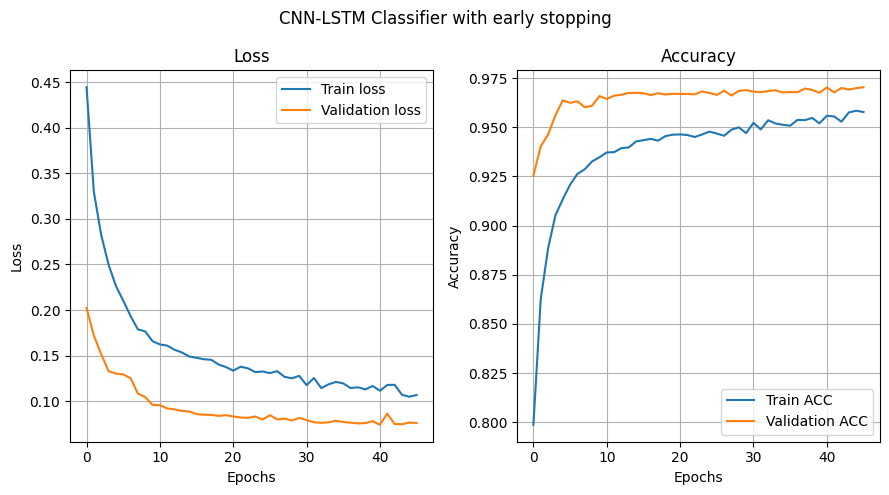

In [35]:
plot_classifier(classifier_history, name='CNN-LSTM Classifier with early stopping')

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      9467
           1       0.74      0.90      0.81       729

    accuracy                           0.97     10196
   macro avg       0.87      0.94      0.90     10196
weighted avg       0.97      0.97      0.97     10196


#################################################################



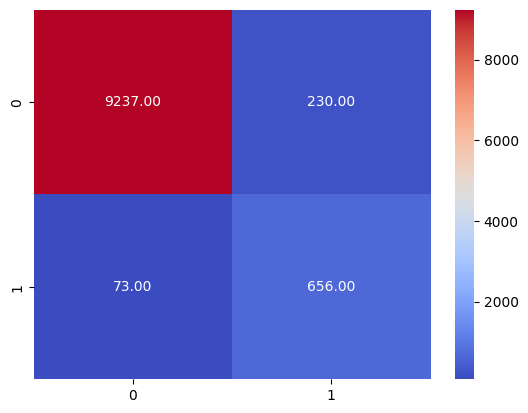


#################################################################



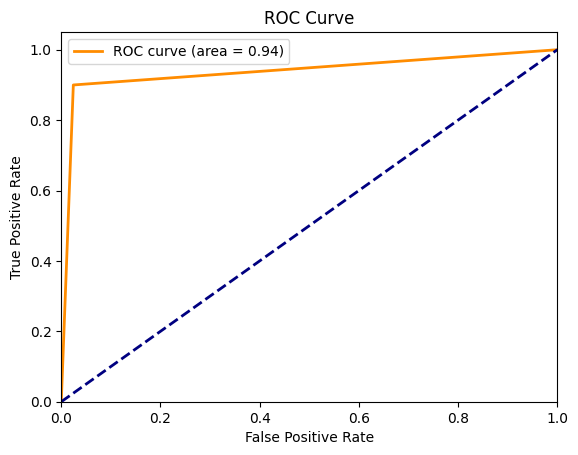

In [36]:
report_matrix_ROC(classifier_model, test_dataset, window_test_target_cls)

# **CNN-LSTM Regressor Model:**

In [30]:
input_shape = (train_vectors.shape[1], train_vectors.shape[2])
input_layer = Input(shape=input_shape)
x = Conv1D(32, 5, activation='relu')(input_layer)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = LSTM(50, return_sequences=True, dropout=0.2)(x)
x = Dropout(0.2)(x)
x = LSTM(50, dropout=0.2)(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
# classification_output = Dense(1, activation='sigmoid', name='classification_output')(x)
regression_output = Dense(1, activation='linear', name='regression_output')(x)
regressor_model = Model(inputs=input_layer, outputs=regression_output) #outputs=[classification_output, regression_output])
regressor_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 26, 32)         │         2,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8, 50)          │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        26,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ regression_output (Dense)       │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,945 (308.38 KB)

 Trainable params: 78,945 (308.38 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
tf.keras.backend.set_epsilon(1)
rmse =tf.keras.metrics.RootMeanSquaredError(name='rmse')

regressor_model.compile(
    optimizer='RMSprop',
    loss= {'regression_output': 'mean_squared_error'},     #{'classification_output': 'binary_crossentropy', 'regression_output': 'mean_squared_error'},
    metrics={'regression_output': ['mae', 'mape', rmse]},            #{'classification_output': ['accuracy'], 'regression_output': ['mse']}
)

regressor_history = regressor_model.fit(train_dataset,
          validation_data=test_dataset,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 4734.9375 - mae: 57.2117 - mape: 153.6228 - rmse: 67.4904 - val_loss: 1624.7164 - val_mae: 36.0107 - val_mape: 36.0856 - val_rmse: 40.3078
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1087.4707 - mae: 27.4028 - mape: 98.0964 - rmse: 32.9637 - val_loss: 669.4604 - val_mae: 21.9447 - val_mape: 26.1478 - val_rmse: 25.8739
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 735.2972 - mae: 21.5577 - mape: 65.3618 - rmse: 27.0621 - val_loss: 568.4886 - val_mae: 19.8258 - val_mape: 23.6082 - val_rmse: 23.8430
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 601.8772 - mae: 19.1622 - mape: 53.7109 - rmse: 24.4801 - val_loss: 501.3276 - val_mae: 18.4136 - val_mape: 21.4309 - val_rmse: 22.3903
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 526.5221 - mae: 17.5652 - mape: 51.8616 - rmse: 22.8782 - val_loss: 439.3479 - val_mae: 17.0347 - val_mape: 19.7333 - val_rmse: 20.9606
Epoch 6/100
89/

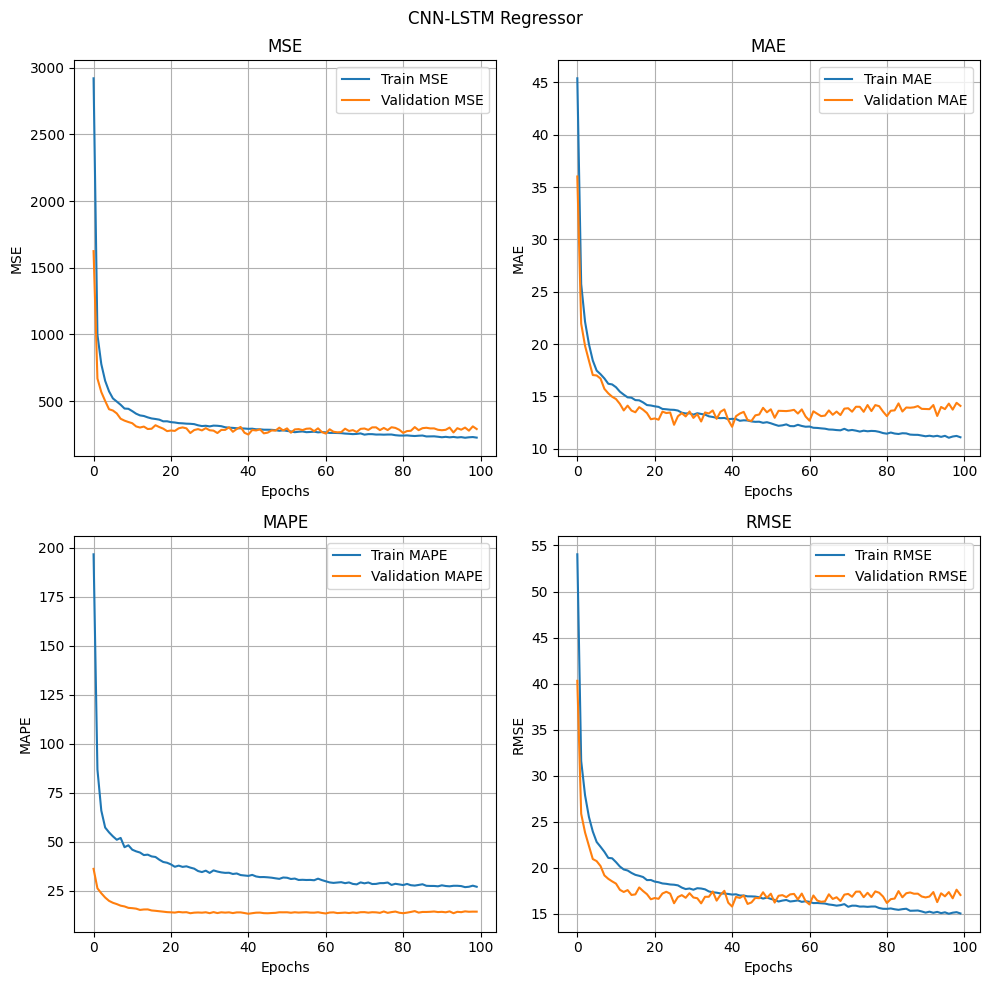

In [32]:
plot_regressor(regressor_history, name='CNN-LSTM Regressor')

In [33]:
X, y = evaluate_model(regressor_model, test_dataset, test_features, RUL_data, window_size=30)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 262.2223 - mae: 13.5593 - mape: 13.1099 - rmse: 16.1816
all_window MSE: 290.92
all_window MAE: 14.09
all_window MAPE: 14.22
all_window RMSE: 17.06

####################################################

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 180.0932 - mae: 10.2703 - mape: 17.9111 - rmse: 13.4158
last_window_per_test_data MSE: 184.63
last_window_per_test_data MAE: 10.28
last_window_per_test_data MAPE: 18.68
last_window_per_test_data RMSE: 13.59

####################################################

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0674 - mae: 0.2596 - mape: 1.2982 - rmse: 0.2596
last_window MSE: 0.07
last_window MAE: 0.26
last_window MAPE: 1.30
last_window RMSE: 0.26


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step


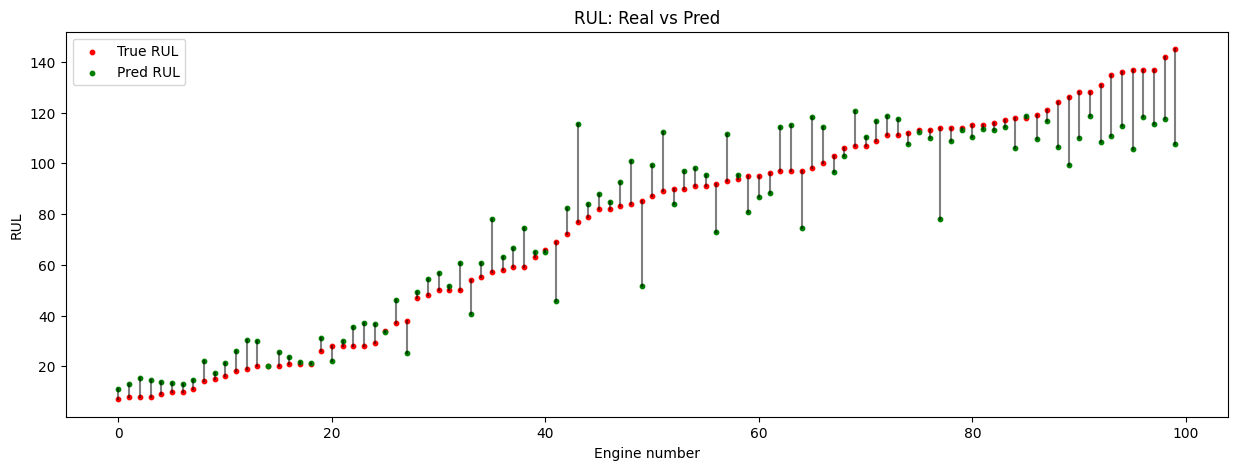

In [34]:
plot_regression_point(regressor_model, X, y, RUL_data, name='RUL: Real vs Pred')

# **Regressor Model with Early Stopping**

In [35]:
input_shape = (train_vectors.shape[1], train_vectors.shape[2])
input_layer = Input(shape=input_shape)
x = Conv1D(32, 5, activation='relu')(input_layer)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = LSTM(50, return_sequences=True, dropout=0.2)(x)
x = Dropout(0.2)(x)
x = LSTM(50, dropout=0.2)(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
# classification_output = Dense(1, activation='sigmoid', name='classification_output')(x)
regression_output = Dense(1, activation='linear', name='regression_output')(x)
regressor_model = Model(inputs=input_layer, outputs=regression_output) #outputs=[classification_output, regression_output])
# regressor_model.summary()

In [36]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# tf.keras.backend.set_epsilon(1)
rmse =tf.keras.metrics.RootMeanSquaredError(name='rmse')

regressor_model.compile(
    optimizer='RMSprop',
    loss= {'regression_output': 'mean_squared_error'},     #{'classification_output': 'binary_crossentropy', 'regression_output': 'mean_squared_error'},
    metrics={'regression_output': ['mae', 'mape', rmse]},            #{'classification_output': ['accuracy'], 'regression_output': ['mse']}
)

regressor_history = regressor_model.fit(train_dataset,
          validation_data=test_dataset,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[early_stopping])

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 4895.8623 - mae: 58.3070 - mape: 150.0488 - rmse: 68.6998 - val_loss: 1680.5000 - val_mae: 37.7499 - val_mape: 43.9692 - val_rmse: 40.9939
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1598.8352 - mae: 34.4594 - mape: 187.3408 - rmse: 39.8824 - val_loss: 765.5235 - val_mae: 23.4699 - val_mape: 26.5360 - val_rmse: 27.6681
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 725.7573 - mae: 21.4475 - mape: 66.8012 - rmse: 26.9044 - val_loss: 607.4223 - val_mae: 20.6245 - val_mape: 23.5147 - val_rmse: 24.6459
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 611.3095 - mae: 19.2490 - mape: 55.7249 - rmse: 24.6669 - val_loss: 493.4392 - val_mae: 18.1082 - val_mape: 21.8475 - val_rmse: 22.2135
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 532.9291 - mae: 17.7062 - mape: 52.7777 - rmse: 23.0298 - val_loss: 441.6806 - val_mae: 17.0556 - val_mape: 20.9059 - val_rmse: 21.0162
Epoch 6/100
89/

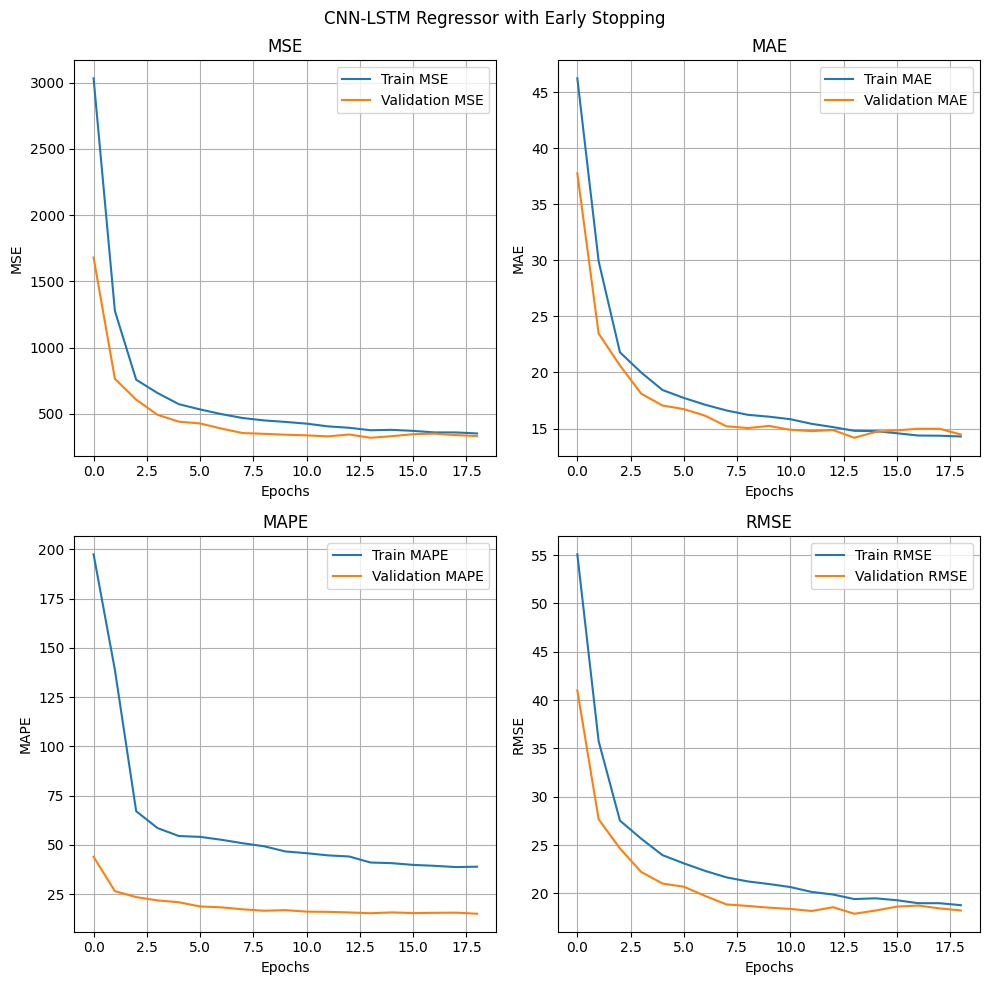

In [37]:
plot_regressor(regressor_history, name='CNN-LSTM Regressor with Early Stopping')

In [38]:
X, y = evaluate_model(regressor_model, test_dataset, test_features, RUL_data, window_size=30)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 274.8380 - mae: 13.2721 - mape: 13.8301 - rmse: 16.5521
all_window MSE: 320.24
all_window MAE: 14.18
all_window MAPE: 15.32
all_window RMSE: 17.90

####################################################

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 253.1205 - mae: 12.0391 - mape: 20.0939 - rmse: 15.8904  
last_window_per_test_data MSE: 273.90
last_window_per_test_data MAE: 12.45
last_window_per_test_data MAPE: 21.59
last_window_per_test_data RMSE: 16.55

####################################################

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.4640 - mae: 0.6812 - mape: 3.4060 - rmse: 0.6812
last_window MSE: 0.46
last_window MAE: 0.68
last_window MAPE: 3.41
last_window RMSE: 0.68


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


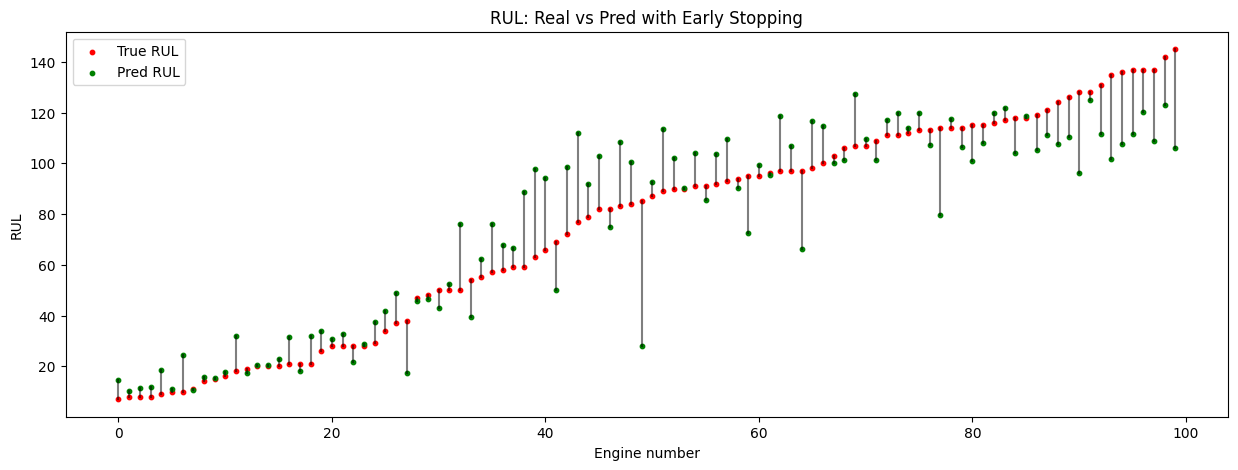

In [39]:
plot_regression_point(regressor_model, X, y, RUL_data, name='RUL: Real vs Pred with Early Stopping')

# **CNN:**

**Classificatin**

In [40]:
input_shape = (train_vectors.shape[1], train_vectors.shape[2])
input_layer = Input(shape=input_shape)
x = Conv1D(32, 5, activation='relu')(input_layer)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
classification_output = Dense(1, activation='sigmoid', name='classification_output')(x)
# regression_output = Dense(1, activation='linear', name='regression_output')(x)
cnn_classifier_model = Model(inputs=input_layer, outputs=classification_output) #outputs=[classification_output, regression_output])
cnn_classifier_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 26, 32)         │         2,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 24, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_output (Dense)   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,913 (292.63 KB)

 Trainable params: 74,913 (292.63 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_classifier_model.compile(
    optimizer='adam',
    loss= {'classification_output': 'binary_crossentropy'},     #{'classification_output': 'binary_crossentropy', 'regression_output': 'mean_squared_error'},
    metrics={'classification_output': ['accuracy']},            #{'classification_output': ['accuracy'], 'regression_output': ['mse']}
)

cnn_classifier_history = cnn_classifier_model.fit(train_dataset,
          validation_data=test_dataset,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[early_stopping])

Epoch 1/100
68/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8054 - loss: 0.4356

I0000 00:00:1716899301.234411     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8162 - loss: 0.4170 - val_accuracy: 0.9393 - val_loss: 0.1798
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8936 - loss: 0.2529 - val_accuracy: 0.9484 - val_loss: 0.1612
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9085 - loss: 0.2267 - val_accuracy: 0.9529 - val_loss: 0.1377
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9226 - loss: 0.1992 - val_accuracy: 0.9623 - val_loss: 0.1226
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9324 - loss: 0.1633 - val_accuracy: 0.9632 - val_loss: 0.1097
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9378 - loss: 0.1466 - val_accuracy: 0.9664 - val_loss: 0.0913
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9415 - loss: 0.1388 - val_accuracy: 0.9666 - val_loss: 0.0869
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9445 - loss: 0.1322 - val_accuracy: 0.9666 - val_loss: 0.

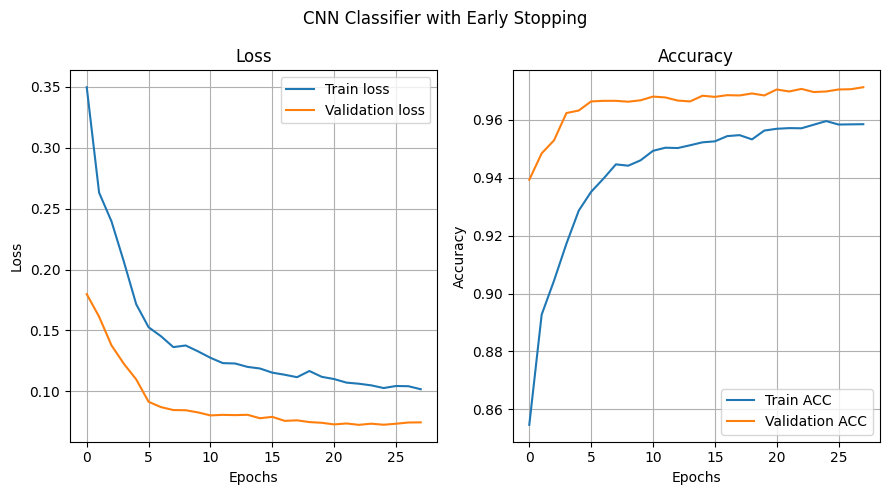

In [42]:
plot_classifier(cnn_classifier_history, name='CNN Classifier with Early Stopping')

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      9387
           1       0.79      0.86      0.82       809

    accuracy                           0.97     10196
   macro avg       0.89      0.92      0.90     10196
weighted avg       0.97      0.97      0.97     10196


#################################################################



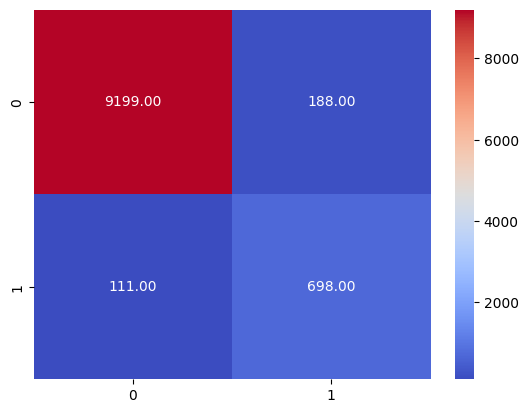


#################################################################



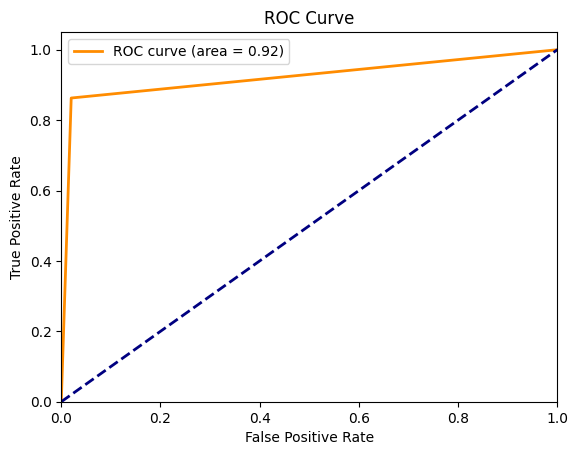

In [43]:
report_matrix_ROC(cnn_classifier_model, test_dataset, window_test_target_cls)

**Regression**

In [44]:
input_shape = (train_vectors.shape[1], train_vectors.shape[2])
input_layer = Input(shape=input_shape)
x = Conv1D(32, 5, activation='relu')(input_layer)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
# classification_output = Dense(1, activation='sigmoid', name='classification_output')(x)
regression_output = Dense(1, activation='linear', name='regression_output')(x)
cnn_regressor_model = Model(inputs=input_layer, outputs=regression_output) #outputs=[classification_output, regression_output])
cnn_regressor_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 30, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 26, 32)         │         2,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 24, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ regression_output (Dense)       │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,913 (292.63 KB)

 Trainable params: 74,913 (292.63 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# tf.keras.backend.set_epsilon(1)
rmse =tf.keras.metrics.RootMeanSquaredError(name='rmse')

cnn_regressor_model.compile(
    optimizer='RMSprop',
    loss= {'regression_output': 'mean_squared_error'},     #{'classification_output': 'binary_crossentropy', 'regression_output': 'mean_squared_error'},
    metrics={'regression_output': ['mae', 'mape', rmse]},            #{'classification_output': ['accuracy'], 'regression_output': ['mse']}
)

cnn_regressor_history = cnn_regressor_model.fit(train_dataset,
          validation_data=test_dataset,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[early_stopping])

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 3463.9336 - mae: 47.6499 - mape: 178.9414 - rmse: 56.9420 - val_loss: 878.1047 - val_mae: 24.5739 - val_mape: 27.4469 - val_rmse: 29.6328
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 651.9600 - mae: 20.0458 - mape: 52.8186 - rmse: 25.4074 - val_loss: 754.0063 - val_mae: 22.1557 - val_mape: 25.1228 - val_rmse: 27.4592
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 570.3268 - mae: 18.2964 - mape: 41.4828 - rmse: 23.7339 - val_loss: 676.4558 - val_mae: 20.8904 - val_mape: 24.1491 - val_rmse: 26.0088
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 539.4274 - mae: 17.6955 - mape: 40.0554 - rmse: 23.0952 - val_loss: 607.0569 - val_mae: 19.5991 - val_mape: 23.3145 - val_rmse: 24.6385
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 512.4143 - mae: 17.1841 - mape: 38.1850 - rmse: 22.5158 - val_loss: 595.1443 - val_mae: 19.4833 - val_mape: 22.6202 - val_rmse: 24.3956
Epoch 6/100
89/89 ━━━━

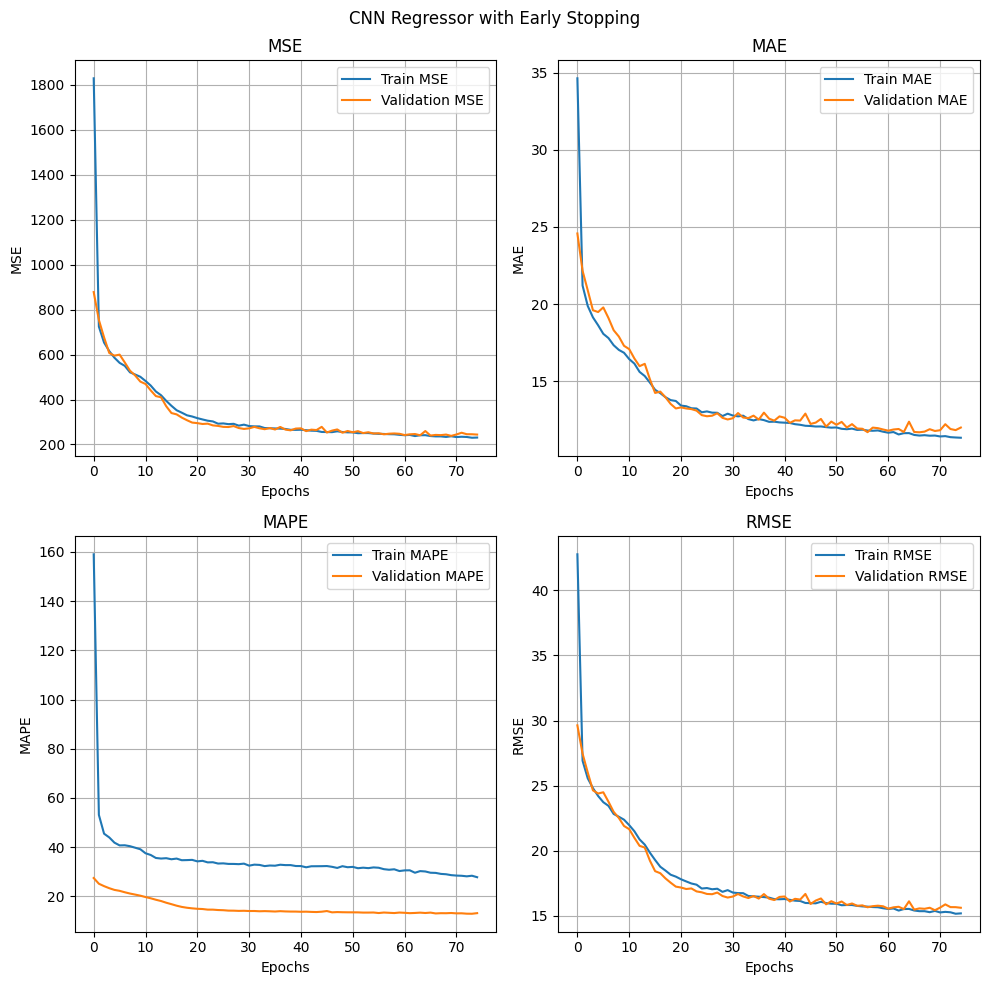

In [46]:
plot_regressor(cnn_regressor_history, name='CNN Regressor with Early Stopping')

In [47]:
X, y = evaluate_model(cnn_regressor_model, test_dataset, test_features, RUL_data, window_size=30)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 211.5788 - mae: 11.0905 - mape: 11.9170 - rmse: 14.5151
all_window MSE: 238.14
all_window MAE: 11.78
all_window MAPE: 13.23
all_window RMSE: 15.43

####################################################

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 214.3869 - mae: 11.2268 - mape: 17.6752 - rmse: 14.6274
last_window_per_test_data MSE: 227.86
last_window_per_test_data MAE: 11.50
last_window_per_test_data MAPE: 18.98
last_window_per_test_data RMSE: 15.09

####################################################

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - loss: 1.8797 - mae: 1.3710 - mape: 6.8552 - rmse: 1.3710
last_window MSE: 1.88
last_window MAE: 1.37
last_window MAPE: 6.86
last_window RMSE: 1.37


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


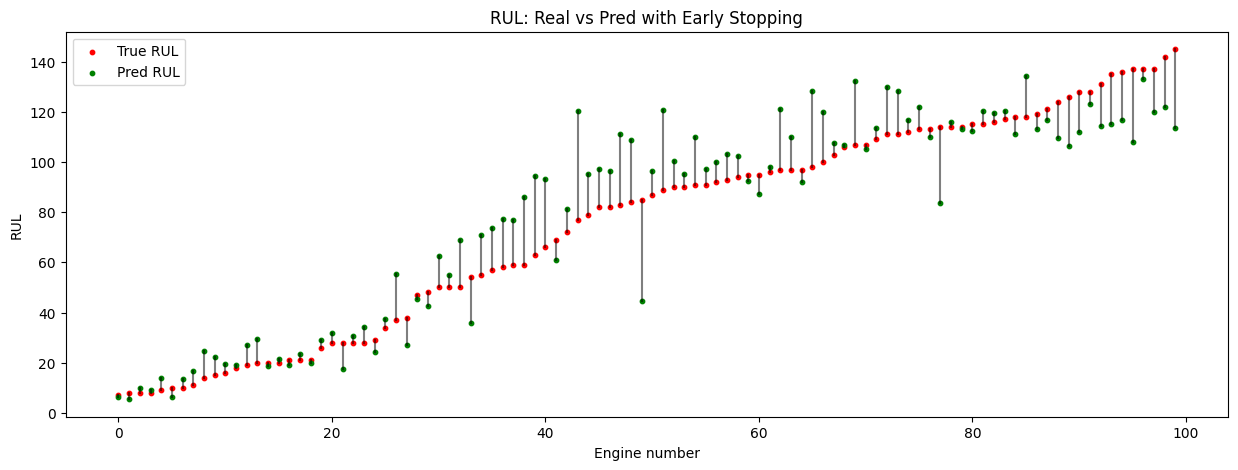

In [48]:
plot_regression_point(cnn_regressor_model, X, y, RUL_data, name='RUL: Real vs Pred with Early Stopping')

# **LSTM:**

In [49]:
input_shape = (train_vectors.shape[1], train_vectors.shape[2])
input_layer = Input(shape=input_shape)
x = LSTM(50, return_sequences=True, dropout=0.2)(input_layer)
x = Dropout(0.2)(x)
x = LSTM(50, dropout=0.2)(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
classification_output = Dense(1, activation='sigmoid', name='classification_output')(x)
# regression_output = Dense(1, activation='linear', name='regression_output')(x)
lstm_classifier_model = Model(inputs=input_layer, outputs=classification_output) #outputs=[classification_output, regression_output])
lstm_classifier_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 30, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 50)         │        13,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_output (Dense)   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,657 (158.82 KB)

 Trainable params: 40,657 (158.82 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm_classifier_model.compile(
    optimizer='adam',
    loss= {'classification_output': 'binary_crossentropy'},     #{'classification_output': 'binary_crossentropy', 'regression_output': 'mean_squared_error'},
    metrics={'classification_output': ['accuracy']},            #{'classification_output': ['accuracy'], 'regression_output': ['mse']}
)

lstm_classifier_history = lstm_classifier_model.fit(train_dataset,
          validation_data=test_dataset,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[early_stopping])

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.7383 - loss: 0.5384 - val_accuracy: 0.9547 - val_loss: 0.2146
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.8622 - loss: 0.3293 - val_accuracy: 0.9567 - val_loss: 0.1642
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.8955 - loss: 0.2556 - val_accuracy: 0.9605 - val_loss: 0.1198
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9136 - loss: 0.2155 - val_accuracy: 0.9504 - val_loss: 0.1371
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9202 - loss: 0.2009 - val_accuracy: 0.9561 - val_loss: 0.1316
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9213 - loss: 0.1954 - val_accuracy: 0.9657 - val_loss: 0.0994
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9232 - loss: 0.1861 - val_accuracy: 0.9601 - val_loss: 0.1245
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.9314 - loss: 0.1741 - val_accuracy: 0

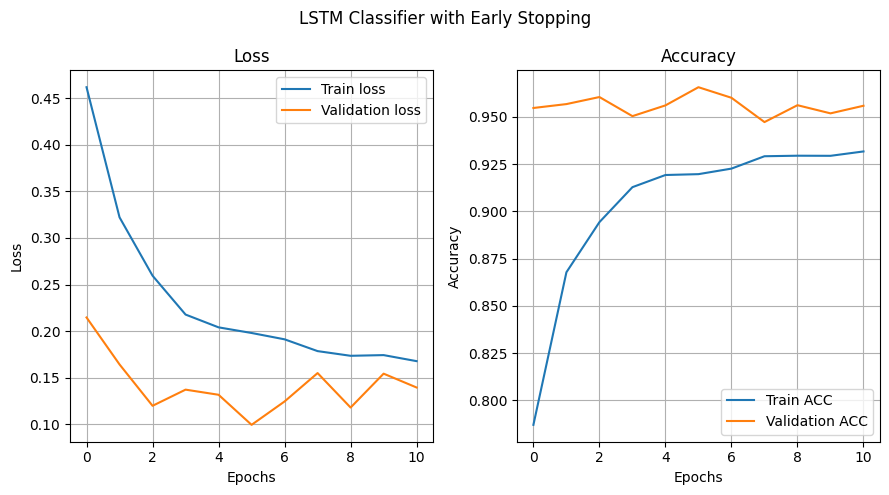

In [51]:
plot_classifier(lstm_classifier_history, name='LSTM Classifier with Early Stopping')


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      9470
           1       0.71      0.87      0.78       726

    accuracy                           0.97     10196
   macro avg       0.85      0.92      0.88     10196
weighted avg       0.97      0.97      0.97     10196


#################################################################



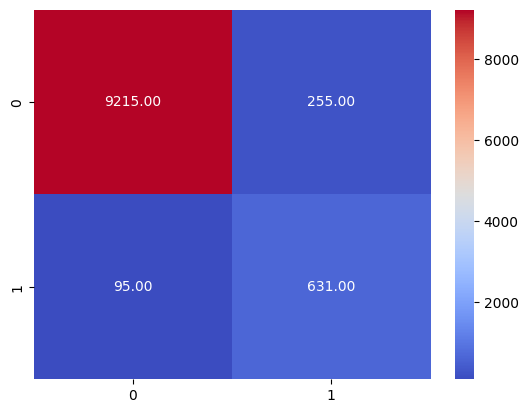


#################################################################



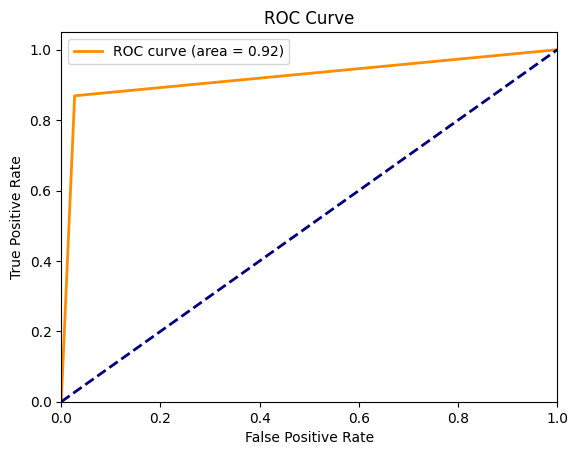

In [52]:
report_matrix_ROC(lstm_classifier_model, test_dataset, window_test_target_cls)

**Regressor**

In [53]:
input_shape = (train_vectors.shape[1], train_vectors.shape[2])
input_layer = Input(shape=input_shape)
x = LSTM(50, return_sequences=True, dropout=0.2)(input_layer)
x = Dropout(0.2)(x)
x = LSTM(50, dropout=0.2)(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
# classification_output = Dense(1, activation='sigmoid', name='classification_output')(x)
regression_output = Dense(1, activation='linear', name='regression_output')(x)
lstm_regressor_model = Model(inputs=input_layer, outputs=regression_output) #outputs=[classification_output, regression_output])
lstm_regressor_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 30, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 30, 50)         │        13,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ regression_output (Dense)       │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,657 (158.82 KB)

 Trainable params: 40,657 (158.82 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# tf.keras.backend.set_epsilon(1)
rmse =tf.keras.metrics.RootMeanSquaredError(name='rmse')

lstm_regressor_model.compile(
    optimizer='RMSprop',
    loss= {'regression_output': 'mean_squared_error'},     #{'classification_output': 'binary_crossentropy', 'regression_output': 'mean_squared_error'},
    metrics={'regression_output': ['mae', 'mape', rmse]},            #{'classification_output': ['accuracy'], 'regression_output': ['mse']}
)

lstm_regressor_history = lstm_regressor_model.fit(train_dataset,
          validation_data=test_dataset,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[early_stopping])


Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 5979.9429 - mae: 65.5991 - mape: 114.7254 - rmse: 76.6624 - val_loss: 1988.8201 - val_mae: 41.0252 - val_mape: 45.1483 - val_rmse: 44.5962
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 1840.3577 - mae: 37.8911 - mape: 223.6144 - rmse: 42.8850 - val_loss: 1507.0044 - val_mae: 32.8119 - val_mape: 30.7309 - val_rmse: 38.8202
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 1022.3276 - mae: 26.2988 - mape: 96.6723 - rmse: 31.9668 - val_loss: 784.1262 - val_mae: 24.3522 - val_mape: 24.7062 - val_rmse: 28.0023
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 751.8255 - mae: 21.7280 - mape: 66.8299 - rmse: 27.3908 - val_loss: 511.4204 - val_mae: 20.0656 - val_mape: 22.4722 - val_rmse: 22.6146
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 631.3245 - mae: 19.5449 - mape: 55.8913 - rmse: 25.0979 - val_loss: 443.7548 - val_mae: 18.7180 - val_mape: 21.5606 - val_rmse: 21.0655
Epoch 6/100


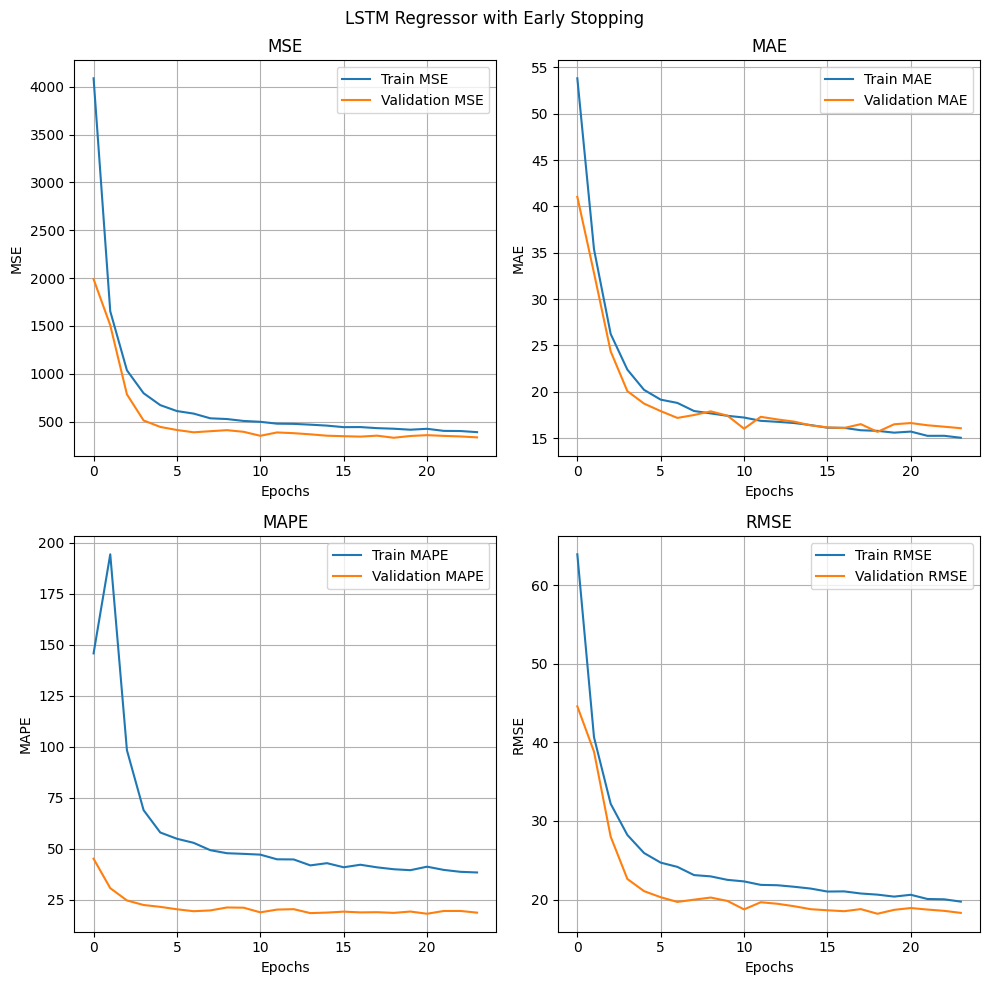

In [55]:
plot_regressor(lstm_regressor_history, name='LSTM Regressor with Early Stopping')

In [56]:
X, y = evaluate_model(lstm_regressor_model, test_dataset, test_features, RUL_data, window_size=30)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 301.1899 - mae: 14.9631 - mape: 16.7425 - rmse: 17.3243
all_window MSE: 330.74
all_window MAE: 15.67
all_window MAPE: 18.61
all_window RMSE: 18.19

####################################################

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 290.7802 - mae: 13.6184 - mape: 32.1257 - rmse: 17.0492
last_window_per_test_data MSE: 297.98
last_window_per_test_data MAE: 13.97
last_window_per_test_data MAPE: 34.39
last_window_per_test_data RMSE: 17.26

####################################################

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 8.3109 - mae: 2.8829 - mape: 14.4143 - rmse: 2.8829
last_window MSE: 8.31
last_window MAE: 2.88
last_window MAPE: 14.41
last_window RMSE: 2.88


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


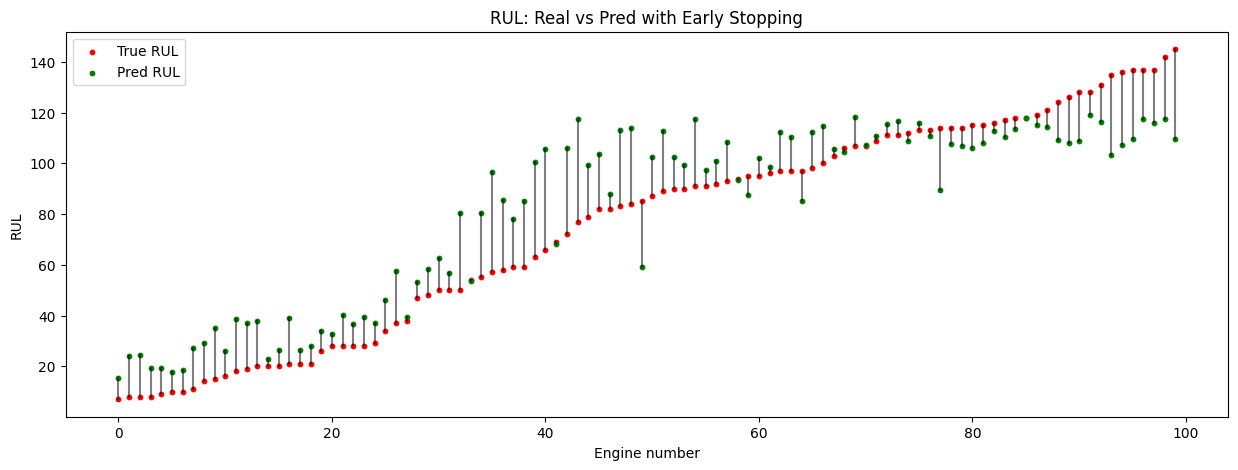

In [57]:
plot_regression_point(lstm_regressor_model, X, y, RUL_data, name='RUL: Real vs Pred with Early Stopping')